<a href="https://colab.research.google.com/github/RONALDP10/Proyecto-SMART-ENERGY-Pron-stico-de-Demanda-El-ctrica-en-Per-/blob/main/BOOTCAMP_PROYECTO_SMART_ENERGY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto de Predicción de Consumo de Energía aplicando *SKFORECAST***

En el prosente trabajo se desarrolla un modelo para pronosticar el valor de consumo de energía en un horizonte de una semana, aplicando Machine Learning mediante la librería *skforecast*

## **Preparación de ambiente de Trabajo**

Se instala la libreria de skforecast la cual no se encuentra habilitada en google colab.

Se cargan las librerías necesarias para el desarrollo del proyecto

In [1]:
pip install -q skforecast

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import TimeSeriesDifferentiator
from sklearn.metrics import mean_squared_error, mean_absolute_error

## **Carga y observación de datos**

Se carga la base de datos la cual corresponde a datos históricos del consumo eléctrico en Perú durante el año 2023 y 2024.

In [3]:
datos = pd.read_excel("Proyecto_Mes_5.xlsx",skiprows=3) #se carga los datos sin considerar las 3 primeras filas
datos.head()

,FECHA,EJECUTADO
0,01/01/2023 00:30,6120.78000
1,01/01/2023 01:00,6010.91339
2,01/01/2023 01:30,5946.83300
3,01/01/2023 02:00,5846.17000
4,01/01/2023 02:30,5756.13500


In [4]:
#Veo la información general de los datos
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29232 entries, 0 to 29231
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FECHA      29232 non-null  object 
 1   EJECUTADO  29232 non-null  float64
dtypes: float64(1), object(1)
memory usage: 456.9+ KB


Se observa que no existen valores nulos. La columna fecha es del tipo object lo cual para el objetivo de este trabajo debe ser cambiado a un tipo de dato más apropiado.

In [5]:
#Modificación del dataframe
datos['FECHA'] = pd.to_datetime(datos['FECHA'], format='%d/%m/%Y %H:%M') #convierto la columna fecha a tipo de dato de fecha con formato específco
datos.set_index('FECHA',inplace=True) # la columna fecha la establezco como índice
datos.rename(columns={'EJECUTADO':'Demanda'},inplace=True) # cambio el nombre de la columna a uno más adecuado
datos = datos.asfreq("30min") # establezco una frecuencia de registro de cada 30 minutos
datos.head()

,Demanda
FECHA,
2023-01-01 00:30:00,6120.78000
2023-01-01 01:00:00,6010.91339
2023-01-01 01:30:00,5946.83300
2023-01-01 02:00:00,5846.17000
2023-01-01 02:30:00,5756.13500


In [6]:
#observo los índices del dataframe
datos.index

DatetimeIndex(['2023-01-01 00:30:00', '2023-01-01 01:00:00',
               '2023-01-01 01:30:00', '2023-01-01 02:00:00',
               '2023-01-01 02:30:00', '2023-01-01 03:00:00',
               '2023-01-01 03:30:00', '2023-01-01 04:00:00',
               '2023-01-01 04:30:00', '2023-01-01 05:00:00',
               ...
               '2024-08-31 19:30:00', '2024-08-31 20:00:00',
               '2024-08-31 20:30:00', '2024-08-31 21:00:00',
               '2024-08-31 21:30:00', '2024-08-31 22:00:00',
               '2024-08-31 22:30:00', '2024-08-31 23:00:00',
               '2024-08-31 23:30:00', '2024-09-01 00:00:00'],
              dtype='datetime64[ns]', name='FECHA', length=29232, freq='30min')

In [7]:
#reviso la información general luego de haber modificado el dataframe
datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29232 entries, 2023-01-01 00:30:00 to 2024-09-01 00:00:00
Freq: 30min
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Demanda  29232 non-null  float64
dtypes: float64(1)
memory usage: 456.8 KB


<Axes: xlabel='FECHA'>

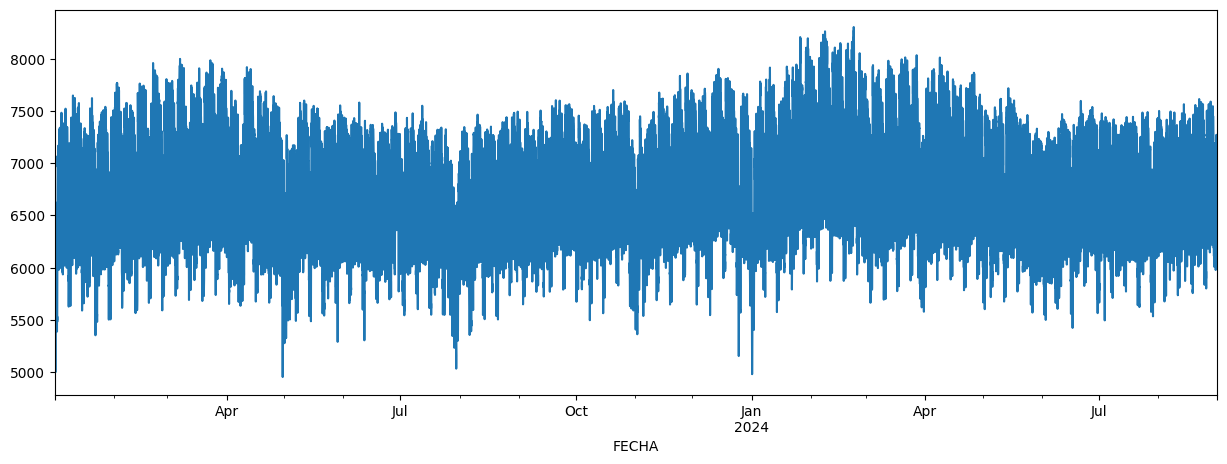

In [8]:
#Grafico la demanda durante el todo el periodo que tengo disponible en los datos
datos.Demanda.plot(figsize=(15,5),label='Consumo Eléctrico')

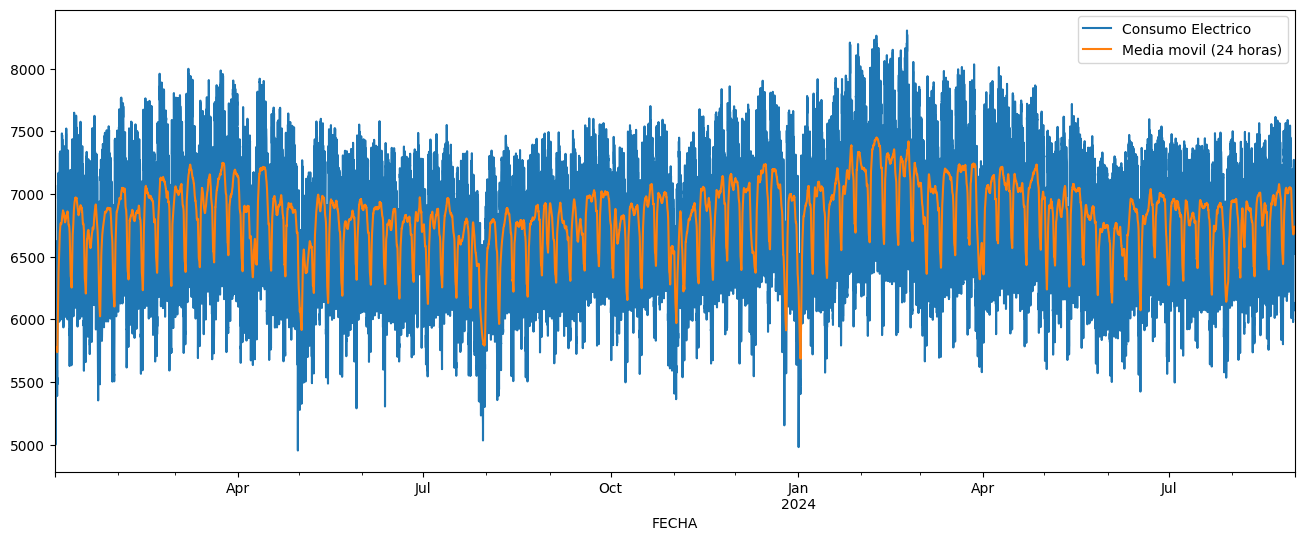

In [9]:
datos.Demanda.plot(figsize=(16,6),label="Consumo Electrico")
datos.Demanda.rolling(48).mean().plot(label='Media movil (24 horas)') #genero una gráfica de la demanda eléctrica aplicando una media movil de las últimas 24 horas.
plt.legend()
plt.show()

En la media móvil, como se tiene registros del consumo cada 30 minutos, es decir se tiene 2 registros cada hora, por lo tanto el valor a colocar es de 48 (24 horas * 2)

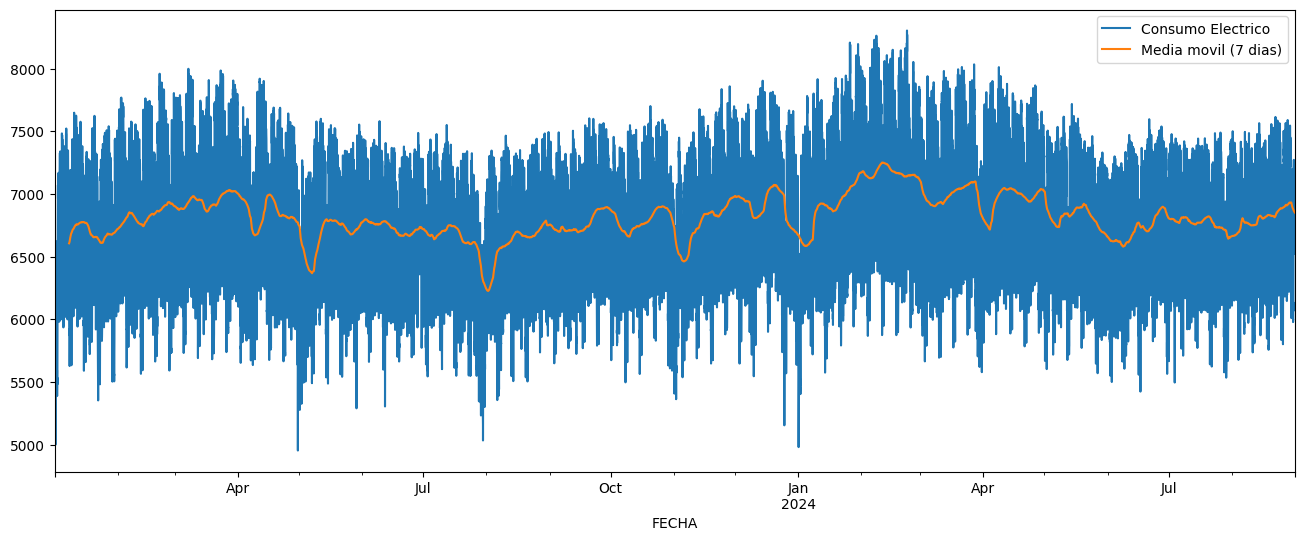

In [10]:
datos.Demanda.plot(figsize=(16,6),label="Consumo Electrico")
datos.Demanda.rolling(48*7).mean().plot(label='Media movil (7 dias)') # genero gráfica de consumo aplicando una media móvil de una semana
plt.legend()
plt.show()

## **Preparación de los Datos.**

Aplicamos *feature engineering* para agregar columnas que sirvan como variables exógenas y mejoren las capacidades predictivas del modelo.

In [11]:
# Se crea una variable "Ciclo"
datos['Ciclo'] = datos.index.map(lambda t: (t.hour * 60 + t.minute) / (24*60))

La variable ciclo da como resultado valores entre 0 y 1 que indica la posición relativa dentro del día de cada registro del índice.

Para esto se calcula la cantidad de minutos transcurridos desde la medianoche sobre el total de minutos que tiene el dia.

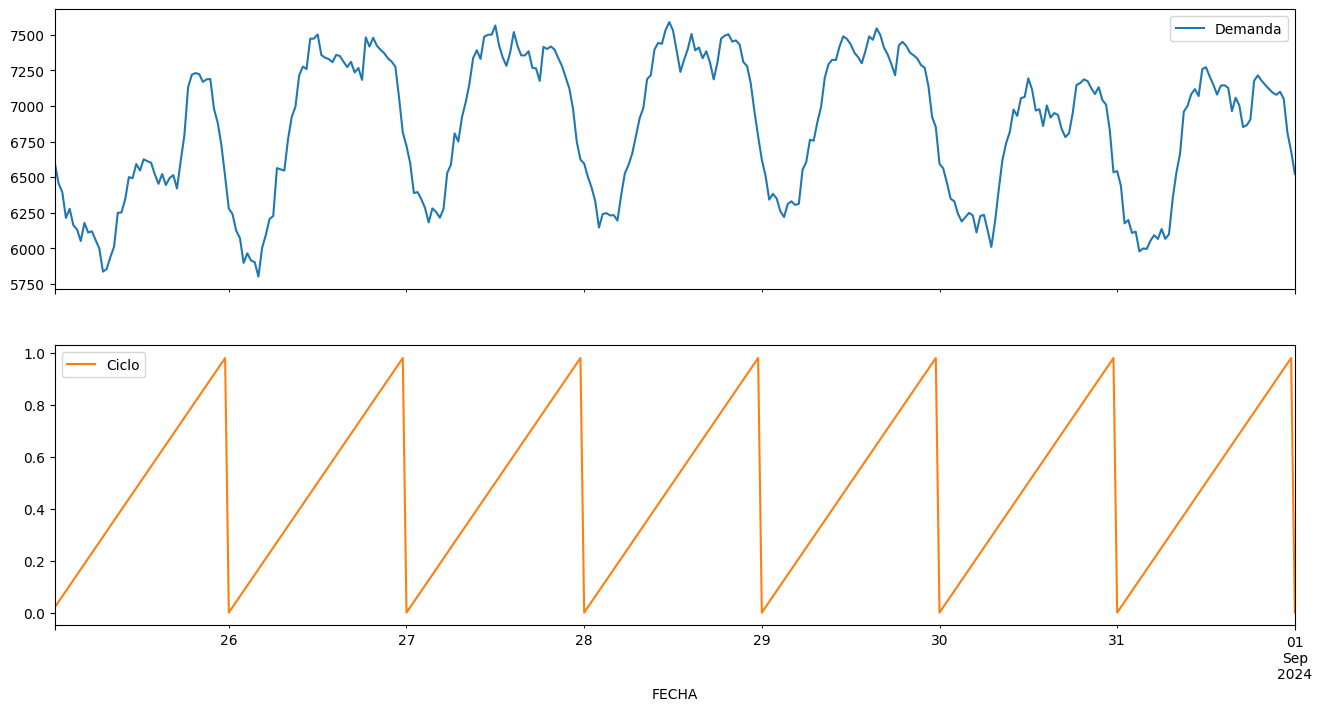

In [12]:
datos[['Demanda','Ciclo']][-48*7:].plot(figsize=(16,8),subplots=True)
plt.show()

### **Efecto Diario**

El modelo debe reconocer que día de la semana es.

In [13]:
#Se crea un diccionario con la finalidad de hacer la traducción de inglés a español
days_translation = {
    'Monday': '1Lunes',
    'Tuesday': '2Martes',
    'Wednesday': '3Miércoles',
    'Thursday': '4Jueves',
    'Friday': '5Viernes',
    'Saturday': '6Sábado',
    'Sunday': '0Domingo'
}

In [14]:
#Creo la columna Dia
datos['Dia'] = datos.index.day_name().map(days_translation) #Se reconoce el día según la fecha en el índice y se mapea al español usando el diccionario creado

In [15]:
datos.head()

,Demanda,Ciclo,Dia
FECHA,,,
2023-01-01 00:30:00,6120.78000,0.020833,0Domingo
2023-01-01 01:00:00,6010.91339,0.041667,0Domingo
2023-01-01 01:30:00,5946.83300,0.062500,0Domingo
2023-01-01 02:00:00,5846.17000,0.083333,0Domingo
2023-01-01 02:30:00,5756.13500,0.104167,0Domingo


In [16]:
#Creo variables dummies a partir de la variable Día
datos2 = pd.get_dummies(datos,columns=['Dia'], dtype=int)

In [17]:
#observo el nombre de las columnas de las variables
datos2.columns

Index(['Demanda', 'Ciclo', 'Dia_0Domingo', 'Dia_1Lunes', 'Dia_2Martes',
       'Dia_3Miércoles', 'Dia_4Jueves', 'Dia_5Viernes', 'Dia_6Sábado'],
      dtype='object')

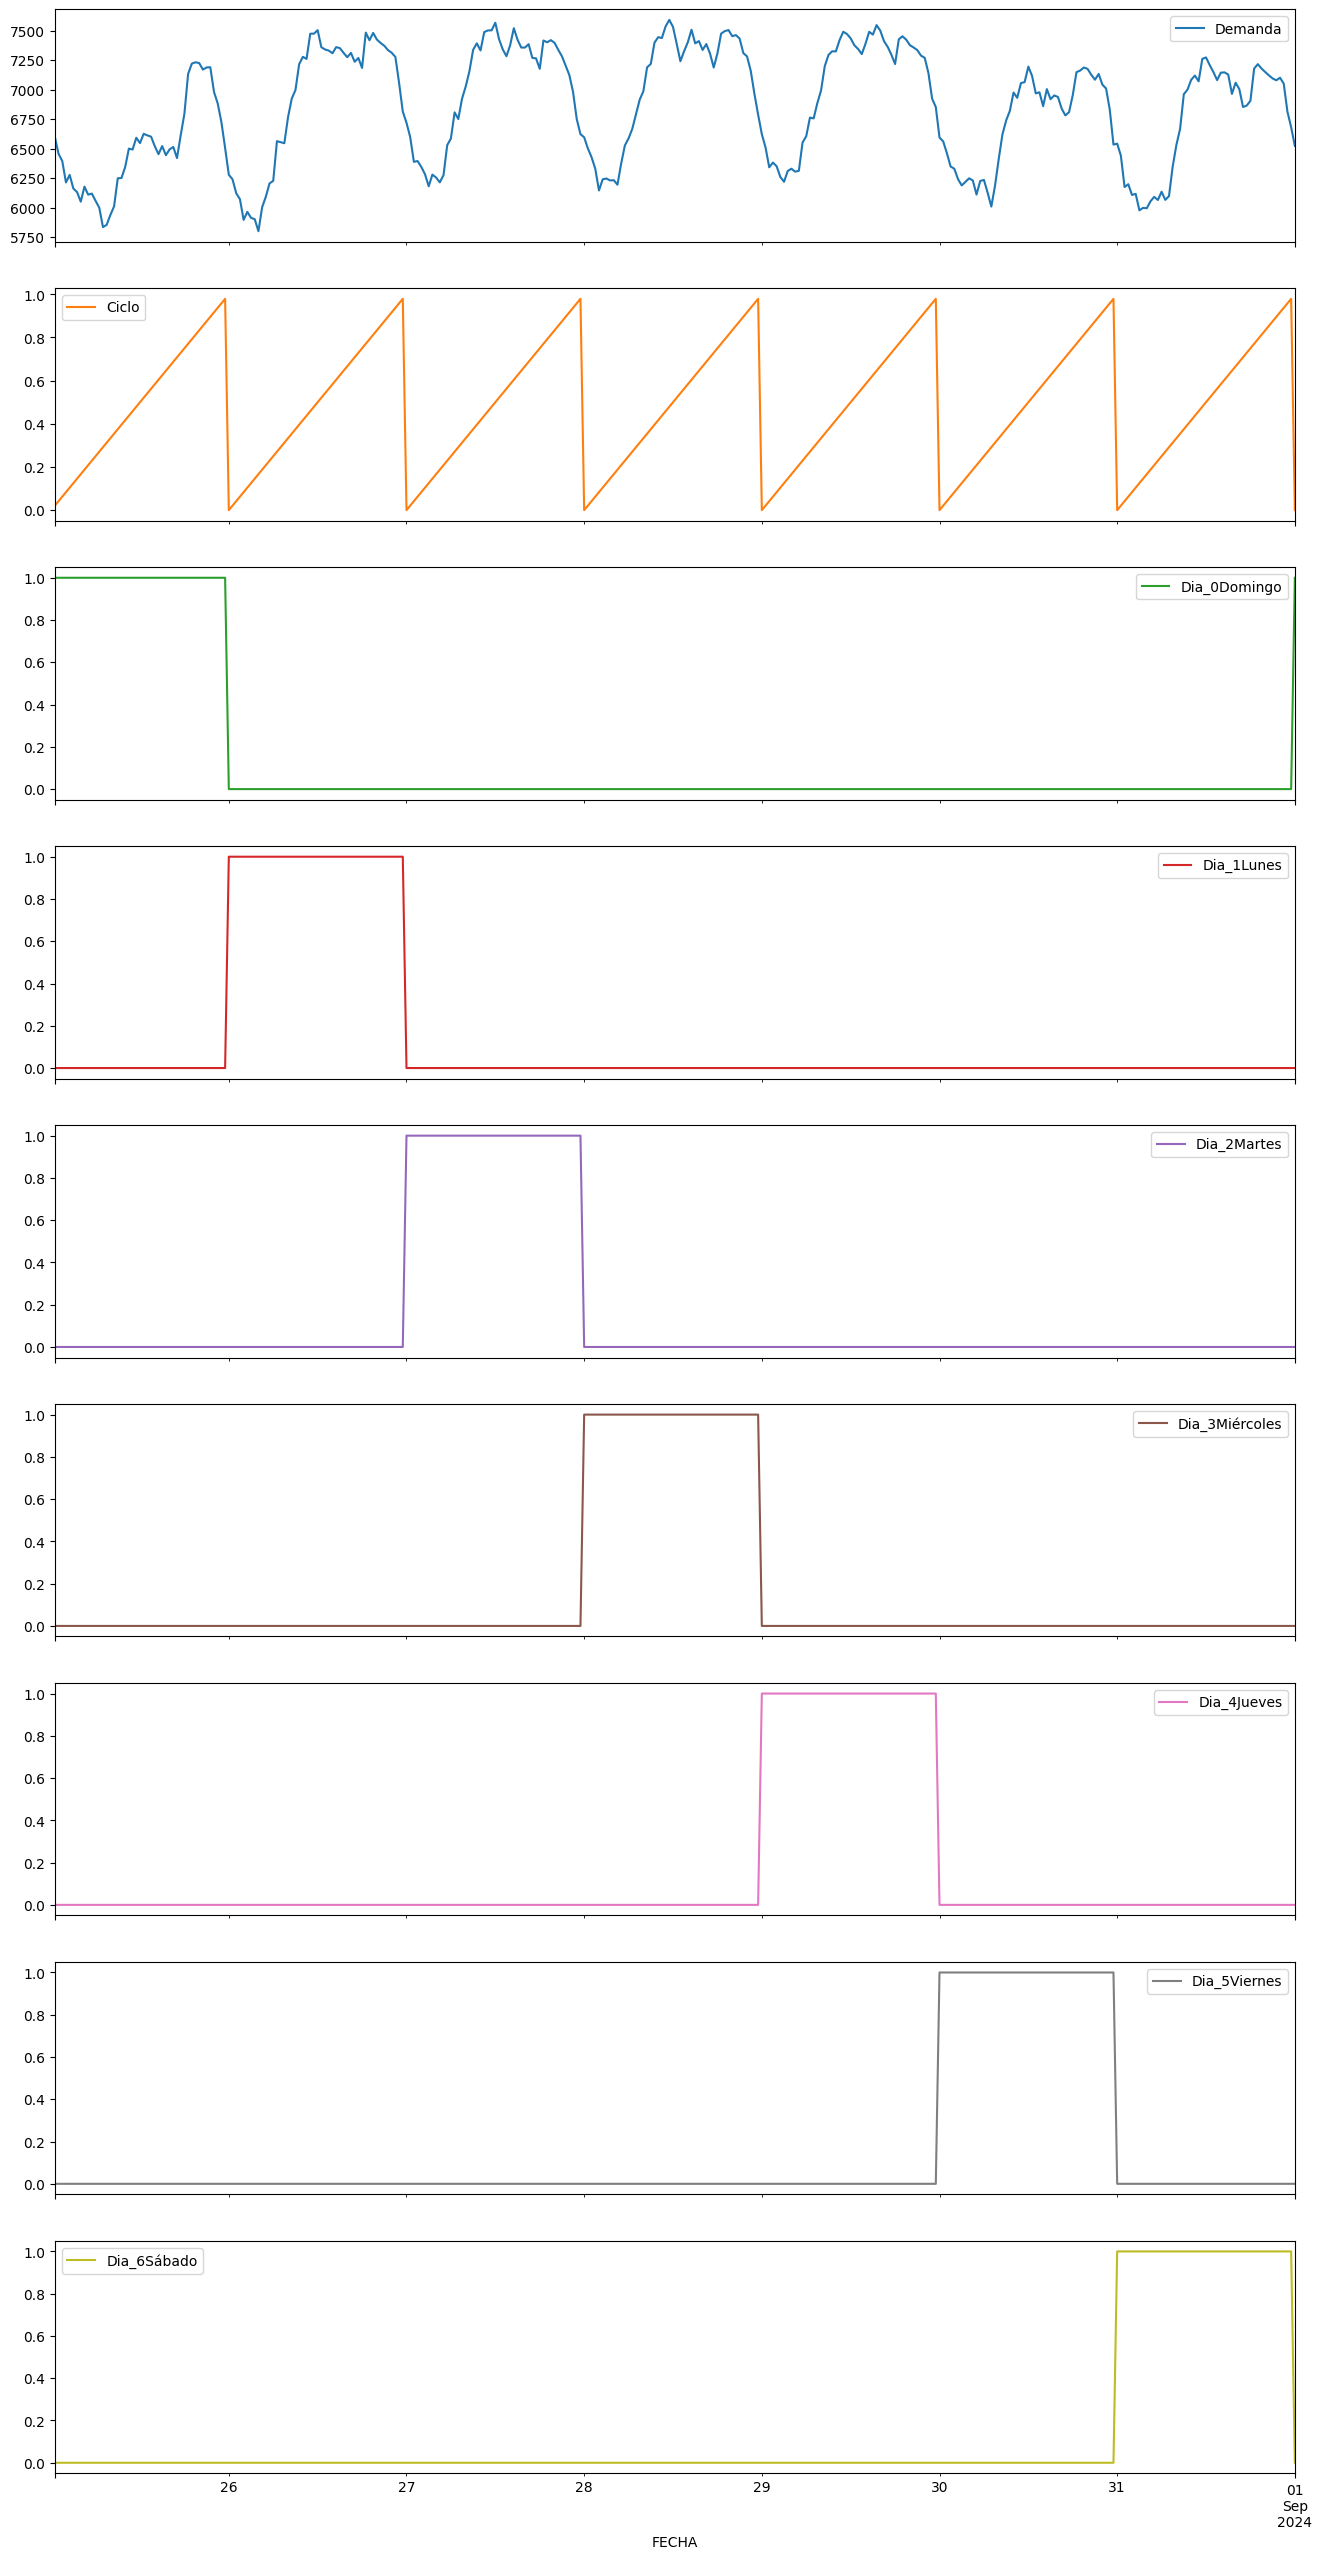

In [18]:
#Grafico la demanda eléctrica, el efecto cíclico y el reconocimiento del día de la última semana dentro de mi dataset
datos2[['Demanda', 'Ciclo', 'Dia_0Domingo', 'Dia_1Lunes', 'Dia_2Martes', 'Dia_3Miércoles', 'Dia_4Jueves', 'Dia_5Viernes', 'Dia_6Sábado']][-48*7:].plot(figsize=(16,32),subplots=True)
plt.show()

### **Efecto Feriado**

El modelo también debe reconocer los días que son feriado en el País.

In [19]:
import holidays

In [20]:
# Se extrae las fechas de feriado en Perú para el año 2023 y 2024
pe = holidays.Peru(years = [2023, 2024], observed = True)

In [21]:
# Se crea una variable booleana que indique 1 en la fecha que sea feriado y 0 en las que no.
datos2['Feriado'] = datos2.index.normalize().isin(pe).astype(int)

/tmp/ipython-input-3873888203.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  datos2['Feriado'] = datos2.index.normalize().isin(pe).astype(int)


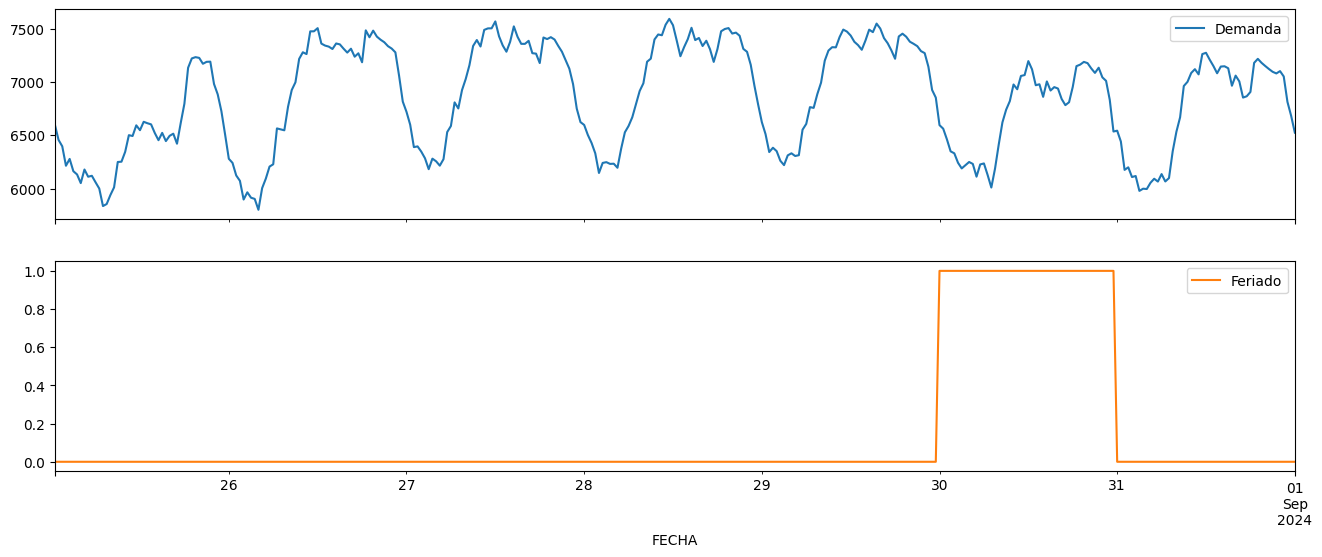

In [22]:
#Se realiza el gráfico de las variables demanda y feriado
datos2[['Demanda','Feriado']][-48*7:].plot(figsize=(16,6),subplots=True)
plt.show()

Se puede observar que existe feriado el 31 de agosto, y la demanda en esa fecha de feriado es menor a los otros dias observados

## **Modelado**

In [23]:
#Se establece el horizonte de observación. En este caso una semana.
steps = 48*7

In [24]:
#Se divide los datos en entrenamiento y prueba
x_train = datos2.drop(columns='Demanda')[:-steps]  # :-steps --> toma todo menos los ultimos registros segun la cantidad de registros de steps
y_train = datos2.Demanda[:-steps]
x_test = datos2.drop(columns='Demanda')[-steps:] # steps: --> toma solo los ultimos registros segun el valor de steps
y_test = datos2.Demanda[-steps:]

In [25]:
#Se genera el modelo de forecasting recursivo
forecaster = ForecasterRecursive(
    regressor=XGBRegressor(random_state=50),
    lags= 48*7
)

Este modelo usará el algoritmo de XGBoost como motor de predicción y para predecir el valor actual el modelo considera la demanda de la última semana completa como variables de entrada (lags=48*7)

In [26]:
#Se define la validación cruzada
cv = TimeSeriesFold(
      steps              = 48,
      initial_train_size = 12 * 7 * 48,
      refit              = False,
      fixed_train_size   = False
    )

* **Steps:** El tamaño de cada bloque de validación es de un día
* **initial_train_size:** La cantidad de observaciones del primer entrenamiento será de aproximadamente 3 meses.
* **texto en negrita**refit: Se indica que el modelo no se re-entrene en cada fold, esto para ahorrar tiempo de cómputo
* **fixed_train_size:** con *False* Se indica que el bloque de entrenamiento va creciendo a medida que avanza la validación

In [27]:
#Entreno el modelo
forecaster.fit(y=y_train)
#Genero las predicciones para un horizonte de una semana
predictions = forecaster.predict(steps=steps)

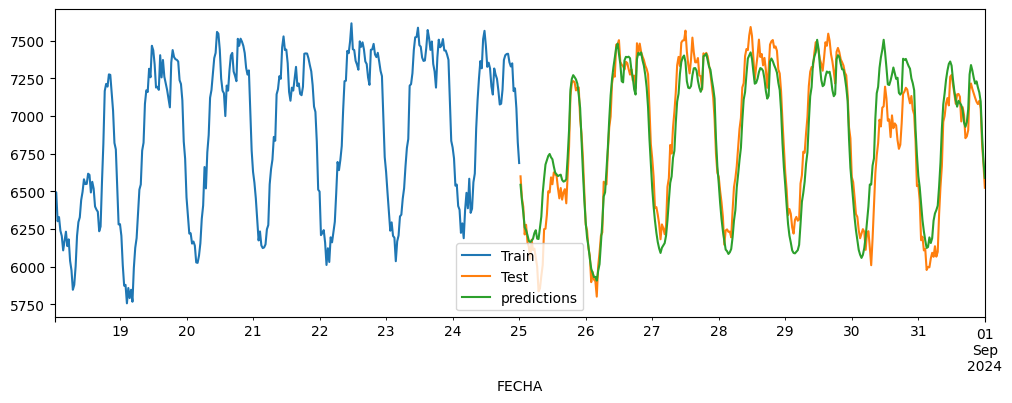

In [28]:
#Visualizo de forma gráfica
fig, ax = plt.subplots(figsize=(12,4))
y_train[-steps:].plot(ax=ax, label='Train')
y_test.plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

**OPTIMIZACIÓN**

Busco la mejor combinación de hiperparámetros para mejorar la eficiencia del modelo

In [29]:
lags_grid = [1, 2, 48, 96, 48*7, 48*14]

param_grid = {
    'n_estimators': [25, 50, 60, 75],
    'max_depth': [3, 4, 6, 8]
}


In [ ]:
results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = y_train,
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False)

In [30]:
regressor = XGBRegressor(max_depth=6, n_estimators=25, random_state=50)

In [42]:
forecaster = ForecasterRecursive(
    regressor=regressor,
    lags= [48, 48*2, 48*7]
)
forecaster.fit(y=y_train)
predictions = forecaster.predict(steps=steps)

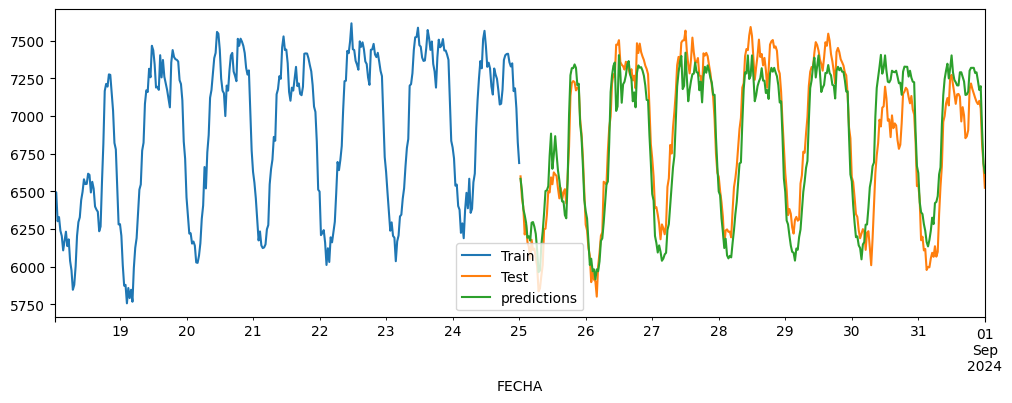

In [43]:
fig, ax = plt.subplots(figsize=(12,4))
y_train[-steps:].plot(ax=ax, label='Train')
y_test.plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

***Métricas de error***

Se calcula el Mean Squared Error (MSE) y el Mean Absolute Error (MAE) comparando los valores reales con las predicciones. Mientras menor sean sus valores significa que mejor es la predicción.

In [44]:
error_mse1 = mean_squared_error(y_test, predictions)
error_mae1 = mean_absolute_error(y_test, predictions)
print(f'MSE: {np.sqrt(error_mse1)}')
print(f'MAE: {error_mae1}')

MSE: 186.46128905497648
MAE: 157.42357081287204


**AGREGO LAS VARIABLES EXOGENAS**

In [35]:
results_grid = grid_search_forecaster(
  forecaster=forecaster,
  y=y_train,
  exog=x_train,
  cv=cv,
  metric = 'mean_squared_error',
  param_grid=param_grid,
  lags_grid=lags_grid
)

lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 3, 'n_estimators': 75}
  Backtesting metric: 43543.493810143555


In [36]:
forecaster = ForecasterRecursive(
    regressor=XGBRegressor(max_depth=3, n_estimators=75, random_state=50),
    lags= [48, 48*2, 48*7] # el modelo considera la demanda exacta de hace un día, de dos dias atras, una semana atrás y un mes atrás
)
forecaster.fit(y=y_train, exog=x_train)
predictions = forecaster.predict(steps=steps, exog=x_test)

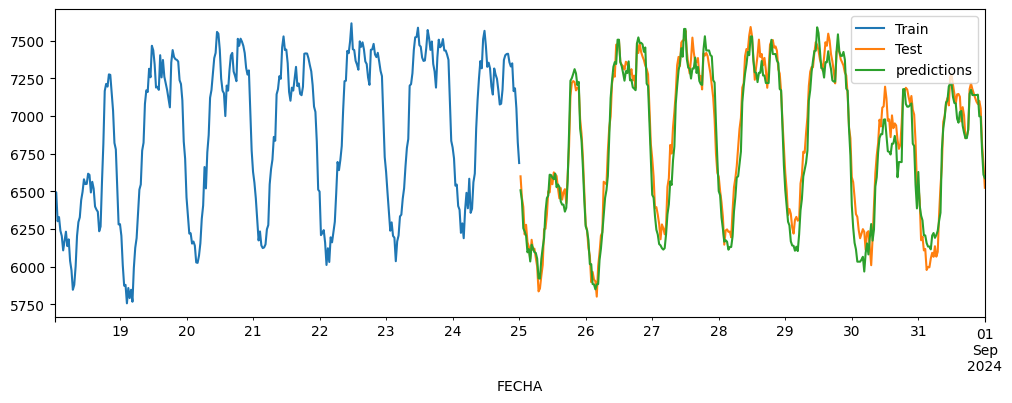

In [37]:
fig, ax = plt.subplots(figsize=(12,4))
y_train[-steps:].plot(ax=ax, label='Train')
y_test.plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

***Métricas de error***

In [40]:
error_mse1 = mean_squared_error(y_test, predictions)
error_mae1 = mean_absolute_error(y_test, predictions)
print(f'MSE: {np.sqrt(error_mse1)}')
print(f'MAE: {error_mae1}')

MSE: 114.11461618022096
MAE: 92.93929541201636


In [45]:
jupyter nbconvert --to html BOOTCAMP_PROYECTO_SMART_ENERGY.ipynb

SyntaxError: invalid syntax (ipython-input-3128353435.py, line 1)